In [3]:
import sys, os
import pandas as pd
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from functools import reduce
from matplotlib.ticker import MaxNLocator
from scipy.stats import ks_2samp

from statannotations.Annotator import Annotator
from statannotations.stats.StatTest import StatTest

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
PERFORMANCE_DATA_DIR = os.path.expanduser("../../data/processed/Performance/")
NAME_FOR_MODEL = "X-CRISP-"
COMMON_ORDER_OF_MODELS = [NAME_FOR_MODEL + "KLD", NAME_FOR_MODEL + "MSE", "FORECasT", "Lindel", "inDelphi", "CROTON"]
sns.set_context("paper")

In [6]:
COMMON_ORDER_OF_MODELS

['X-CRISP-KLD', 'X-CRISP-MSE', 'FORECasT', 'Lindel', 'inDelphi', 'CROTON']

In [7]:
def plot_boxplots(df, y, x = "Method", col="Dataset", func="max", padding=1.45, includeSwarm=True):
    methods = df["Method"].unique()
    print(methods)
    order = [o for o in COMMON_ORDER_OF_MODELS if o in methods]

    g = sns.catplot(data=df, y=y, x="Method", col=col, order=order, kind="box", palette="colorblind", height=4.8, aspect=1.1)
    ax1, ax2 = g.axes[0]
    # if includeSwarm:
    #     sns.swarmplot(data=df[df.Dataset == "FORECasT mESC"], y=y, x="Method", order=order, color=".15", ax=ax1, size=.5)
    #     sns.swarmplot(data=df[df.Dataset == "inDelphi mESC"], y=y, x="Method", order=order, color=".15", ax=ax2, size=.5)
    print([col, "Method"])
    maxes = getattr(df.drop("Target Site", axis=1).groupby([col, "Method"]).median().groupby([col]), func)()

    
    ax1.axhline(maxes.loc["FORECasT mESC", y], ls="--")
    ax2.axhline(maxes.loc["inDelphi mESC", y], ls="--")

    pairs = [(NAME_FOR_MODEL + "KLD", m) for m in order[1:]]
    alternative = "greater" if func == "max" else "less"

    custom_long_name = "Two-sample Kolmogorov-Smirnov test"
    custom_short_name = ""
    custom_func = ks_2samp
    custom_test = StatTest(custom_func, custom_long_name, custom_short_name)

    annotator = Annotator(ax1, pairs, data=df[df[col] == "FORECasT mESC"], x=x, y=y, order=order)
    annotator.configure(test="Wilcoxon", text_format='star', loc='outside')
    annotator.apply_test(alternative="two-sided")
    annotator.annotate()
    ax1.set_title("Dataset = FORECasT mESC", fontsize = 10, y=padding)
    ax1.set_xlabel("")

    annotator = Annotator(ax2, pairs, data=df[df[col] == "inDelphi mESC"], x=x, y=y, order=order)
    annotator.configure(test="Wilcoxon", text_format='star', loc='outside')
    annotator.apply_test(alternative="two-sided")
    annotator.annotate()
    ax2.set_title("Dataset = inDelphi mESC", fontsize = 10, y=padding)
    ax2.set_ylabel("")
    ax2.set_xlabel("")

    plt.tight_layout()

    return g

In [8]:
def name_correction(df):
    df.loc[df["Method"] == "KLD", "Method"] = NAME_FOR_MODEL + "KLD"
    df.loc[df["Method"] == "1NN", "Method"] = NAME_FOR_MODEL + "MSE"
    df.loc[df["Dataset"] == "FORECasT WT", "Dataset"] = "FORECasT mESC"
    df.loc[df["Dataset"] == "inDelphi WT", "Dataset"] = "inDelphi mESC"
    return df

def data_correction(df, rename):
    df = df.rename(columns={"0": rename})
    df.loc[df["Method"] == "KLD", "Method"] = NAME_FOR_MODEL + "KLD"
    df.loc[df["Method"] == "1NN", "Method"] = NAME_FOR_MODEL + "MSE"
    df = df.loc[~(df["Method"] == "1NN")]
    df.loc[df["Dataset"] == "FORECasT WT", "Dataset"] = "FORECasT mESC"
    df.loc[df["Dataset"] == "inDelphi WT", "Dataset"] = "inDelphi mESC"
    return df

['X-CRISP-MSE' 'X-CRISP-KLD' 'inDelphi' 'Lindel' 'FORECasT']
['Dataset', 'Method']
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

X-CRISP-KLD vs. X-CRISP-MSE: Wilcoxon test (paired samples), P_val:3.885e-09 Stat=3.106e+06
X-CRISP-KLD vs. FORECasT: Wilcoxon test (paired samples), P_val:1.708e-01 Stat=3.404e+06
X-CRISP-KLD vs. Lindel: Wilcoxon test (paired samples), P_val:1.972e-216 Stat=1.422e+06
X-CRISP-KLD vs. inDelphi: Wilcoxon test (paired samples), P_val:0.000e+00 Stat=5.488e+05
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

X-CRISP-KLD vs. X-CRISP-MSE: Wilcoxon test (paired samples), P_val:8.770e-07 Stat=8.350e+05
X-CRISP-KLD vs. FORECasT: Wilcoxon test (paired samples), P_val:1.432e-05 Stat=8.495e+05
X-CRISP-KLD vs. 

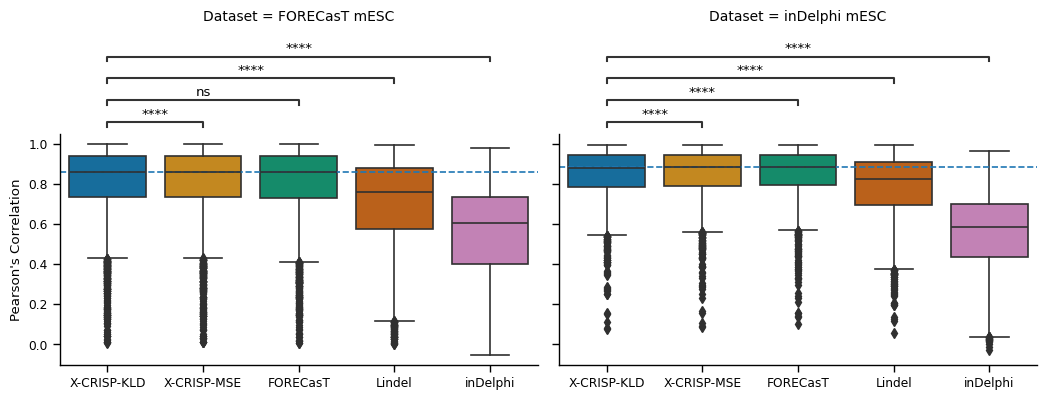

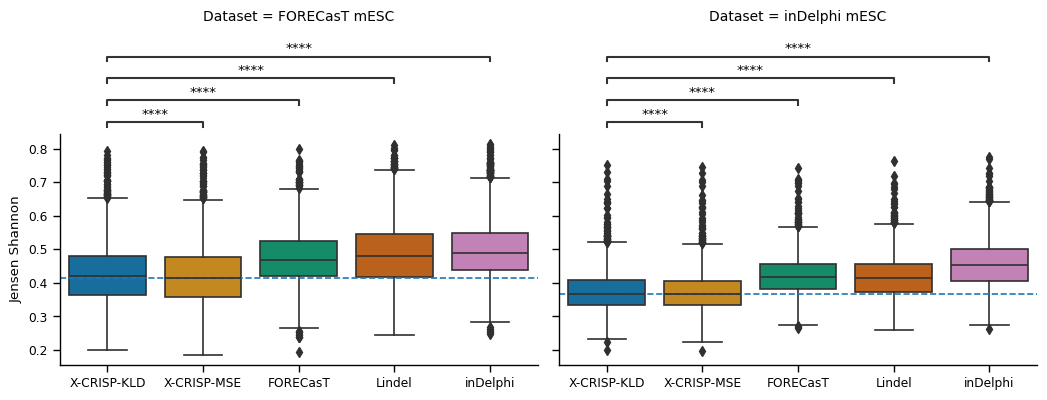

In [9]:
overall_df = name_correction(pd.read_csv(PERFORMANCE_DATA_DIR + "overall.tsv", sep="\t"))
# plot_boxplots(overall_df, y="KL Divergence", func="min")
# plt.savefig("./images/performance_kl_div.pdf", facecolor="white", bbox_inches='tight')

plot_boxplots(overall_df, y="Pearson's Correlation", func="max")
plot_boxplots(overall_df, y="Jensen Shannon", func="min")

In [10]:
overall_df.head()

,Dataset,Method,Target Site,Pearson's Correlation,KL Divergence,Jensen Shannon
0,FORECasT mESC,X-CRISP-MSE,Oligo_10007,0.453150,1.696266,0.581045
1,FORECasT mESC,X-CRISP-MSE,Oligo_10019,0.896817,0.808918,0.421618
2,FORECasT mESC,X-CRISP-MSE,Oligo_10026,0.895545,1.089849,0.485740
3,FORECasT mESC,X-CRISP-MSE,Oligo_10060,0.318250,1.625313,0.605609
4,FORECasT mESC,X-CRISP-MSE,Oligo_1007,0.928644,0.932116,0.425363


In [11]:
# insdelratio_df = name_correction(pd.read_csv(PERFORMANCE_DATA_DIR + "insertion-to-deletion.tsv", sep="\t")).loc[:, ["Dataset", "Method", "Deletion/1BP Insertion Ratio"]].rename(columns={"Deletion/1BP Insertion Ratio": "Mean Squared Error"})
# insdelratio_df["Category"] = "Deletion/1BP Insertion Ratio"


# g2 = sns.catplot(data=insdelratio_df, 
#     x="Mean Squared Error", 
#     y="Method", 
#     col="Category", 
#     row="Dataset",
#     order=COMMON_ORDER_OF_MODELS[:-1], 
#     kind="bar", 
#     palette="colorblind", 
#     sharey="row",
#     height=3, 
#     aspect=1.1)

# plt.show()

In [12]:
insertion_df = name_correction(pd.read_csv(PERFORMANCE_DATA_DIR + "insertion.tsv", sep="\t"))
insertion_df["Category"] = "Insertions"

FORECasT mESC Overall
inDelphi mESC Overall
FORECasT mESC MH-based deletions
inDelphi mESC MH-based deletions
FORECasT mESC MH-less deletions
inDelphi mESC MH-less deletions
FORECasT mESC 1BP insertions
inDelphi mESC 1BP insertions


/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_70842/1372954536.py:140: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  b.set_yticklabels([""] * 6)
/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_70842/1372954536.py:140: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  b.set_yticklabels([""] * 6)
/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_70842/1372954536.py:140: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  b.set_yticklabels([""] * 6)
/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_70842/1372954536.py:140: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  b.set_yticklabels([""] * 6)
/var/folders/5x/n2td64g918lgvdh3

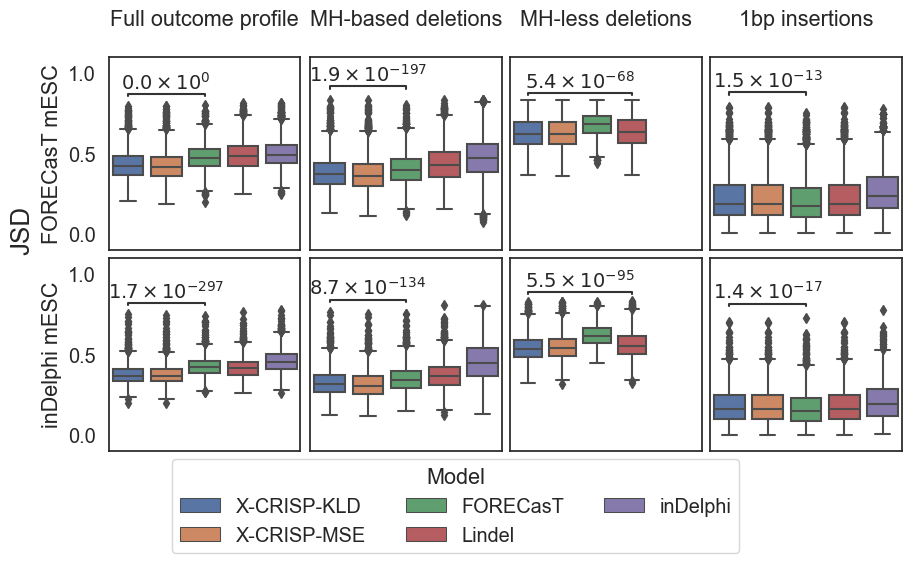

In [28]:
import scipy

metric = "Jensen Shannon"
# metric = "KL Divergence"
# metric = "Pearson's Correlation"

mhless_df = name_correction(pd.read_csv(PERFORMANCE_DATA_DIR + "mhless.tsv", sep="\t"))
mhless_df["Category"] = "MH-Less Deletions"
mh_df = name_correction(pd.read_csv(PERFORMANCE_DATA_DIR + "mh.tsv", sep="\t"))
mh_df["Category"] = "MH Deletions"
insertion_df = name_correction(pd.read_csv(PERFORMANCE_DATA_DIR + "insertion.tsv", sep="\t"))
insertion_df["Category"] = "Insertions"
remove_from_insertions = insertion_df[insertion_df.isnull().any(axis=1)]["Target Site"].unique()
insertion_df = insertion_df[~insertion_df["Target Site"].isin(remove_from_insertions)]

categories_df = pd.concat([mh_df, mhless_df, insertion_df])

sns.set(font_scale=1.3)
sns.set_style("white")

FORECasT_mESC = "FORECasT mESC"
inDelphi_mESC = "inDelphi mESC"

fig, axes = plt.subplots(2, 4, figsize=(9, 4.5), constrained_layout = True)
loc = "inside"
pad = None

if metric == "Jensen Shannon":
    fig.supylabel("JSD")
elif metric == "KL Divergence":
    fig.supylabel(metric)
    loc="outside"
    pad=20
else:
    fig.supylabel("Person's Correlation Coef.")
    loc="outside"
    pad=20


colors = sns.color_palette("deep")[:5]

sns.boxplot(data=overall_df[overall_df.Dataset == FORECasT_mESC], y=metric, x="Method", palette="deep", order=COMMON_ORDER_OF_MODELS[:-1], ax=axes[0,0])
sns.boxplot(data=overall_df[overall_df.Dataset == inDelphi_mESC], y=metric, x="Method", palette="deep", hue="Method", order=COMMON_ORDER_OF_MODELS[:-1], hue_order=COMMON_ORDER_OF_MODELS[:-1], ax=axes[1,0])
handles, labels = axes[1,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(.5, -.24), ncols=3, title="Model")
axes[1,0].clear()
sns.boxplot(data=overall_df[overall_df.Dataset == inDelphi_mESC], y=metric, x="Method", palette="deep", order=COMMON_ORDER_OF_MODELS[:-1], ax=axes[1,0])


sns.boxplot(data=mh_df[mh_df.Dataset == FORECasT_mESC], y=metric, x="Method", palette="deep", order=COMMON_ORDER_OF_MODELS[:-1], ax=axes[0,1])
sns.boxplot(data=mh_df[mh_df.Dataset == inDelphi_mESC], y=metric, x="Method", palette="deep", order=COMMON_ORDER_OF_MODELS[:-1], ax=axes[1,1])

sns.boxplot(data=mhless_df[mhless_df.Dataset == FORECasT_mESC], y=metric, x="Method", palette="deep", order=COMMON_ORDER_OF_MODELS[:-1], ax=axes[0,2])
sns.boxplot(data=mhless_df[mhless_df.Dataset == inDelphi_mESC], y=metric, x="Method", palette="deep", order=COMMON_ORDER_OF_MODELS[:-1], ax=axes[1,2])

sns.boxplot(data=insertion_df[insertion_df.Dataset == FORECasT_mESC], y=metric, x="Method", palette="deep", order=COMMON_ORDER_OF_MODELS[:-1], ax=axes[0,3])
sns.boxplot(data=insertion_df[insertion_df.Dataset == inDelphi_mESC], y=metric, x="Method", palette="deep", order=COMMON_ORDER_OF_MODELS[:-1], ax=axes[1,3])

# sns.barplot(data=insdelratio_df[insdelratio_df.Dataset == FORECasT_mESC], y="Mean Squared Error", x="Method", palette="deep", order=COMMON_ORDER_OF_MODELS[:-1], edgecolor=".05", linewidth=.75, ax=axes[0,4])
# sns.barplot(data=insdelratio_df[insdelratio_df.Dataset == inDelphi_mESC], y="Mean Squared Error", x="Method", palette="deep", order=COMMON_ORDER_OF_MODELS[:-1], edgecolor=".05", linewidth=.75, ax=axes[1,4])

def do_test(df, dataset, pairs, metric):
    pvalues = []
    df = df[df.Dataset == dataset]
    for a, b in pairs:
        a = df[df.Method == a][metric]
        b = df[df.Method == b][metric]
        pvalues.append(scipy.stats.wilcoxon(a, b, alternative="two-sided").pvalue)
    formatted_pvalues = [scientific_to_superscript(pvalue) for pvalue in pvalues]
    return formatted_pvalues

def scientific_to_superscript(value):
    """
    Convert a float in scientific notation to a string in the form `3.4x10^{-5}` for LaTeX rendering.
    """
    if isinstance(value, (int, float)):
        # Format the float in scientific notation and replace 'e' with 'x10^{'
        formatted = "{:.1e}".format(value)  # Format with 1 decimal place
        base, exponent = formatted.split('e')
        return "${" + str(base) + r"} \times 10^{" + str(int(exponent)) + "}$" 
    return value

annot_fontsize = 14
print(FORECasT_mESC, "Overall")
annotator = Annotator(axes[0, 0], [(f"{NAME_FOR_MODEL}KLD", "FORECasT")], data=overall_df[overall_df.Dataset == FORECasT_mESC], y=metric, x="Method", order=COMMON_ORDER_OF_MODELS[:-1])
annotator.configure(text_format='simple', loc=loc, verbose=False, fontsize=annot_fontsize)
annotator.set_custom_annotations(do_test(overall_df, FORECasT_mESC, annotator.pairs, metric))
annotator.annotate()

print(inDelphi_mESC, "Overall")
annotator = Annotator(axes[1, 0], [(f"{NAME_FOR_MODEL}KLD", "FORECasT")], data=overall_df[overall_df.Dataset == inDelphi_mESC], y=metric, x="Method", order=COMMON_ORDER_OF_MODELS[:-1])
annotator.configure(text_format='simple', loc=loc, verbose=False, fontsize=annot_fontsize)
annotator.set_custom_annotations(do_test(overall_df, inDelphi_mESC, annotator.pairs, metric))
annotator.annotate()

print(FORECasT_mESC, "MH-based deletions")
annotator = Annotator(axes[0, 1], [(f"{NAME_FOR_MODEL}KLD", "FORECasT")], data=mh_df[mh_df.Dataset == FORECasT_mESC], y=metric, x="Method", order=COMMON_ORDER_OF_MODELS[:-1])
annotator.configure(text_format='simple', loc=loc, verbose=False, fontsize=annot_fontsize)
annotator.set_custom_annotations(do_test(mh_df, FORECasT_mESC, annotator.pairs, metric))
annotator.annotate()

print(inDelphi_mESC, "MH-based deletions")
annotator = Annotator(axes[1, 1], [(f"{NAME_FOR_MODEL}KLD", "FORECasT")], data=mh_df[mh_df.Dataset == inDelphi_mESC], y=metric, x="Method", order=COMMON_ORDER_OF_MODELS[:-1])
annotator.configure(text_format='simple', loc=loc, verbose=False, fontsize=annot_fontsize)
annotator.set_custom_annotations(do_test(mh_df, inDelphi_mESC, annotator.pairs, metric))
annotator.annotate()

print(FORECasT_mESC, "MH-less deletions")
annotator = Annotator(axes[0, 2], [(f"{NAME_FOR_MODEL}KLD", "Lindel" if metric in ["Jensen Shannon", "KL Divergence"] else "FORECasT")], data=mhless_df[mhless_df.Dataset == FORECasT_mESC], y=metric, x="Method", order=COMMON_ORDER_OF_MODELS[:-2])
annotator.configure(text_format='simple', loc=loc, verbose=False, fontsize=annot_fontsize)
annotator.set_custom_annotations(do_test(mhless_df, FORECasT_mESC, annotator.pairs, metric))
annotator.annotate()

print(inDelphi_mESC, "MH-less deletions")
annotator = Annotator(axes[1, 2], [(f"{NAME_FOR_MODEL}KLD", "Lindel" if metric in ["Jensen Shannon", "KL Divergence"] else "FORECasT")], data=mhless_df[mhless_df.Dataset == inDelphi_mESC], y=metric, x="Method", order=COMMON_ORDER_OF_MODELS[:-2])
annotator.configure(text_format='simple', loc=loc, verbose=False, fontsize=annot_fontsize)
annotator.set_custom_annotations(do_test(mhless_df, inDelphi_mESC, annotator.pairs, metric))
annotator.annotate()

print(FORECasT_mESC, "1BP insertions")
annotator = Annotator(axes[0, 3], [(f"{NAME_FOR_MODEL}KLD", "FORECasT")], data=insertion_df[insertion_df.Dataset == FORECasT_mESC], y=metric, x="Method", order=COMMON_ORDER_OF_MODELS[:-1])
annotator.configure(text_format='simple', loc=loc, verbose=False, fontsize=annot_fontsize)
annotator.set_custom_annotations(do_test(insertion_df, FORECasT_mESC, annotator.pairs, metric))
annotator.annotate()

print(inDelphi_mESC, "1BP insertions")
annotator = Annotator(axes[1, 3], [(f"{NAME_FOR_MODEL}KLD", "FORECasT")], data=insertion_df[insertion_df.Dataset == inDelphi_mESC], y=metric, x="Method", order=COMMON_ORDER_OF_MODELS[:-1])
annotator.configure(text_format='simple', loc=loc, verbose=False, fontsize=annot_fontsize)
annotator.set_custom_annotations(do_test(insertion_df, inDelphi_mESC, annotator.pairs, metric))
annotator.annotate()

for i, a in enumerate(axes):
    for j, b in enumerate(a):
        if j != 4: b.set_ylim(-0.1, 1.1)
        if j == 4: 
            b.set_ylim(0,0.02)
            b.yaxis.set_major_locator(MaxNLocator(5)) 
        if j not in [0, 4]:
            b.set_ylabel("")
            b.set_yticklabels([""] * 6)
        b.set_title("") 
        b.set_xlabel("")
        b.set_xticklabels([""] * 5)
        

axes[0, 0].set_title("Full outcome profile\n", pad=pad) 
axes[0, 1].set_title("MH-based deletions\n", pad=pad) 
axes[0, 2].set_title("MH-less deletions\n", pad=pad) 
axes[0, 3].set_title("1bp insertions\n", pad=pad) 

axes[0, 2].set_xticks([1,2,3,4,5])
axes[1, 2].set_xticks([1,2,3,4,5])


axes[0, 0].set_ylabel("FORECasT mESC") 
axes[1, 0].set_ylabel("inDelphi mESC") 

plt.savefig(f"./artifacts/individual_outcome_performance_comparison_{metric}.pdf", facecolor="white", bbox_inches='tight')

plt.show()

In [29]:
testdf = mhless_df.set_index(["Dataset", "Method", "Target Site"]).sort_index()
a = testdf.loc["FORECasT mESC"].loc[f"{NAME_FOR_MODEL}KLD"][metric]
idx = a.index
b = testdf.loc["FORECasT mESC"].loc["FORECasT"][metric].loc[idx]
# scipy.stats.wilcoxon(a.values, b.values, alternative="two-sided").pvalue

In [30]:
import numpy as np
np.median(a)

0.6199516595220309

In [31]:
np.median(b)

0.67879546799371

In [32]:
overall_df.groupby(["Dataset", "Method"]).mean()

Pearson's Correlation  KL Divergence  \
Dataset       Method                                              
FORECasT mESC FORECasT                  0.808166       1.006983   
              Lindel                    0.704007       1.227826   
              X-CRISP-KLD               0.807170       0.947403   
              X-CRISP-MSE               0.809523       0.962321   
              inDelphi                  0.559852       1.567642   
inDelphi mESC FORECasT                  0.850388       0.756300   
              Lindel                    0.782519       0.885720   
              X-CRISP-KLD               0.845209       0.701901   
              X-CRISP-MSE               0.847973       0.718534   
              inDelphi                  0.551572       1.080269   

                           Jensen Shannon  
Dataset       Method                       
FORECasT mESC FORECasT           0.473340  
              Lindel             0.485124  
              X-CRISP-KLD        0.427136  
              X-CRISP-MSE        0.422319  
              inDelphi           0.495571  
inDelphi mESC FORECasT           0.422774  
              Lindel             0.419050  
              X-CRISP-KLD        0.376567  
              X-CRISP-MSE        0.373690  
              inDelphi           0.458516

In [33]:
mh_df.groupby(["Dataset", "Method"]).mean()

Pearson's Correlation  KL Divergence  \
Dataset       Method                                              
FORECasT mESC FORECasT                  0.810218       0.726056   
              Lindel                    0.718656       0.938523   
              X-CRISP-KLD               0.816015       0.700319   
              X-CRISP-MSE               0.820142       0.709015   
              inDelphi                  0.644897       1.114311   
inDelphi mESC FORECasT                  0.850355       0.535036   
              Lindel                    0.784875       0.663864   
              X-CRISP-KLD               0.854902       0.499115   
              X-CRISP-MSE               0.861207       0.496333   
              inDelphi                  0.600633       0.979540   

                           Jensen Shannon  
Dataset       Method                       
FORECasT mESC FORECasT           0.403390  
              Lindel             0.435969  
              X-CRISP-KLD        0.379584  
              X-CRISP-MSE        0.371023  
              inDelphi           0.468116  
inDelphi mESC FORECasT           0.349633  
              Lindel             0.370221  
              X-CRISP-KLD        0.325553  
              X-CRISP-MSE        0.315144  
              inDelphi           0.458862

In [34]:
mhless_df.groupby(["Dataset", "Method"]).mean()

Pearson's Correlation  KL Divergence  \
Dataset       Method                                              
FORECasT mESC FORECasT                  0.508695       2.375331   
              Lindel                    0.468319       2.310856   
              X-CRISP-KLD               0.475207       2.200699   
              X-CRISP-MSE               0.467629       2.239868   
inDelphi mESC FORECasT                  0.623287       1.771776   
              Lindel                    0.582507       1.616749   
              X-CRISP-KLD               0.587618       1.485561   
              X-CRISP-MSE               0.578963       1.558970   

                           Jensen Shannon  
Dataset       Method                       
FORECasT mESC FORECasT           0.678785  
              Lindel             0.634852  
              X-CRISP-KLD        0.624153  
              X-CRISP-MSE        0.625448  
inDelphi mESC FORECasT           0.620706  
              Lindel             0.560701  
              X-CRISP-KLD        0.542779  
              X-CRISP-MSE        0.548173

In [35]:
insertion_df.groupby(["Dataset", "Method"]).mean()

Pearson's Correlation  KL Divergence  \
Dataset       Method                                              
FORECasT mESC FORECasT                  0.643820       0.237548   
              Lindel                    0.660266       0.255870   
              X-CRISP-KLD               0.660266       0.255870   
              X-CRISP-MSE               0.660266       0.255870   
              inDelphi                  0.575531       0.323109   
inDelphi mESC FORECasT                  0.732948       0.152163   
              Lindel                    0.727372       0.182091   
              X-CRISP-KLD               0.727372       0.182091   
              X-CRISP-MSE               0.727372       0.182091   
              inDelphi                  0.689167       0.216699   

                           Jensen Shannon  
Dataset       Method                       
FORECasT mESC FORECasT           0.211060  
              Lindel             0.220596  
              X-CRISP-KLD        0.220596  
              X-CRISP-MSE        0.220596  
              inDelphi           0.260699  
inDelphi mESC FORECasT           0.167334  
              Lindel             0.182301  
              X-CRISP-KLD        0.182301  
              X-CRISP-MSE        0.182301  
              inDelphi           0.205430

In [36]:
overall_df.groupby(["Dataset", "Method"]).size()

Dataset        Method     
FORECasT mESC  FORECasT       3738
               Lindel         3738
               X-CRISP-KLD    3738
               X-CRISP-MSE    3738
               inDelphi       3738
inDelphi mESC  FORECasT       1957
               Lindel         1957
               X-CRISP-KLD    1957
               X-CRISP-MSE    1957
               inDelphi       1957
dtype: int64

In [37]:
overall_df[overall_df.Dataset == FORECasT_mESC]\
    .groupby(["Dataset", "Method"])\
    .mean()

Pearson's Correlation  KL Divergence  \
Dataset       Method                                              
FORECasT mESC FORECasT                  0.808166       1.006983   
              Lindel                    0.704007       1.227826   
              X-CRISP-KLD               0.807170       0.947403   
              X-CRISP-MSE               0.809523       0.962321   
              inDelphi                  0.559852       1.567642   

                           Jensen Shannon  
Dataset       Method                       
FORECasT mESC FORECasT           0.473340  
              Lindel             0.485124  
              X-CRISP-KLD        0.427136  
              X-CRISP-MSE        0.422319  
              inDelphi           0.495571

In [38]:
summary_df = data_correction(pd.read_csv(PERFORMANCE_DATA_DIR + "stats_comparison.tsv", sep="\t"), rename="").set_index(["Dataset", "Method"]).rename(columns={
    "Deletion Frequency Corr": "Deletion Corr",
    "1BP Insertion Frequency Corr": "1BP Insertion Corr",
    "1BP Deletion Frequency Corr": "1BP Deletion Corr",
})
countplot_d = summary_df.stack().reset_index().rename(columns={"level_2": "Statistic", 0: "Mean Squared Error"})
# countplot_d["Statistic"] = countplot_d["Statistic"].str[:-5]

# fig, axes = plt.subplots(1, 2, figsize=(9, 4))

# kwargs = {
#     "x": "Statistic",
#     "y": "Mean Squared Error",
#     "hue": "Method", 
#     "palette": "deep",
#     "hue_order": COMMON_ORDER_OF_MODELS,
# }
# g = sns.barplot(data=countplot_d[countplot_d.Dataset == "FORECasT mESC"], ax=axes[0], **kwargs)
# sns.barplot(data=countplot_d[countplot_d.Dataset == "inDelphi mESC"], ax=axes[1], **kwargs)

g = sns.catplot(data=countplot_d[countplot_d.Dataset != "LUMC WT"], x="Statistic", y="Mean Squared Error", \
    hue="Method", kind="bar", palette="deep", col="Dataset", col_wrap=2, legend=False, hue_order=COMMON_ORDER_OF_MODELS \
        , height=3.8, aspect=1.1, edgecolor="none")
for ax in g.axes:
    ax.set_xticklabels([a.get_text().capitalize() for a in ax.get_xticklabels()], rotation=45, ha='right')
    ax.set_xlabel("")

g.axes[0].set_title("FORECasT mESC")
g.axes[1].set_title("inDelphi mESC")

handles = g._legend_data.values()
labels = g._legend_data.keys()

g.fig.legend(handles=handles, labels=labels, loc='lower center', ncol=3, bbox_to_anchor=(.5, -0.22), title="Model")

plt.tight_layout()
# plt.show()
plt.savefig("./artifacts/highlevel_performance_comparison.pdf", facecolor="white", bbox_inches='tight', dpi=600)

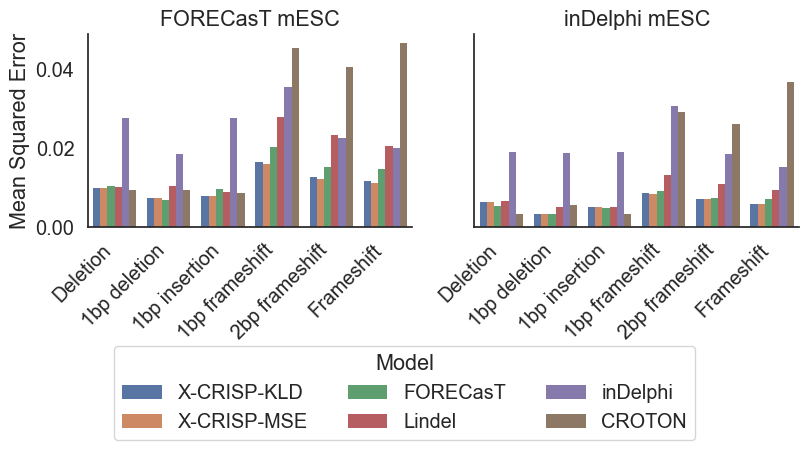

In [39]:
plt.show()

In [40]:
summary_df.groupby(["Dataset", "Method"]).size()

Dataset        Method     
FORECasT mESC  CROTON         1
               FORECasT       1
               Lindel         1
               X-CRISP-KLD    1
               X-CRISP-MSE    1
               inDelphi       1
inDelphi mESC  CROTON         1
               FORECasT       1
               Lindel         1
               X-CRISP-KLD    1
               X-CRISP-MSE    1
               inDelphi       1
dtype: int64

In [41]:
summary_df = data_correction(pd.read_csv(PERFORMANCE_DATA_DIR + "stats_comparison_corr.tsv", sep="\t"), rename="").set_index(["Dataset", "Method"]).rename(columns={
    "Deletion Frequency Corr": "Deletion Corr",
    "1BP Insertion Frequency Corr": "1BP Insertion Corr",
    "1BP Deletion Frequency Corr": "1BP Deletion Corr",
})
countplot_d = summary_df.stack().reset_index().rename(columns={"level_2": "Statistic", 0: "Pearson's Correlation Coef."})

g = sns.catplot(data=countplot_d[countplot_d.Dataset != "LUMC WT"], x="Statistic", y="Pearson's Correlation Coef.", \
    hue="Method", kind="bar", palette="deep", col="Dataset", col_wrap=2, legend=False, hue_order=COMMON_ORDER_OF_MODELS \
        , height=3.8, aspect=1.1, edgecolor="none")
for ax in g.axes:
    ax.set_xticklabels([a.get_text().capitalize() for a in ax.get_xticklabels()], rotation=45, ha='right')
    ax.set_xlabel("")

g.axes[0].set_title("FORECasT mESC")
g.axes[1].set_title("inDelphi mESC")

handles = g._legend_data.values()
labels = g._legend_data.keys()

g.fig.legend(handles=handles, labels=labels, loc='lower center', ncol=3, bbox_to_anchor=(.5, -0.22), title="Model")

plt.tight_layout()
# plt.show()
plt.savefig("./artifacts/highlevel_performance_comparison_corr.pdf", facecolor="white", bbox_inches='tight', dpi=600)

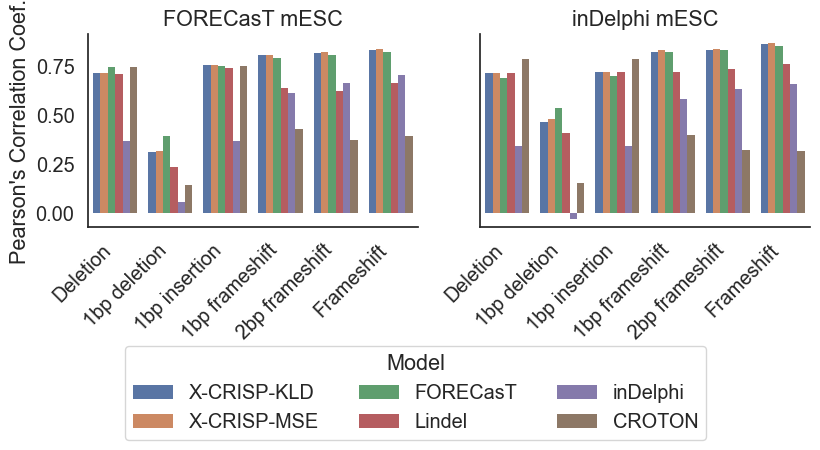

In [42]:
plt.show()